# CATCHM [DEMO]

CATCHM combines Deepwalk [Perozzi et al., 2014], a network representation learning algorithm, with a powerful boosted tree model for fraud detection (XGBoost). The transductive deepwalk model is augmented with an inductive pooling extension, which enables online fraud detection without lengthy retraining.

This demo notebook contains an overview of the CATCHM approach. The following code sources are used:
- Deepwalk: https://pypi.org/project/nodevectors/
- XGBoost: https://pypi.org/project/xgboost/
- Inductive extension: https://pypi.org/project/fucc/

Before running the demo, please download the demo dataset from Kaggle:
https://www.kaggle.com/ranjeetshrivastav/fraud-detection-dataset

For a baseline without representation learning, please refer to the Pagerank demo notebook

-----

In [1]:
from catchm import Catchm
import pandas as pd
import numpy as np
from fucc.metrics import plot_ap, get_optimal_f1_cutoff, get_confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

In [2]:
# Parameters
dimensions = 32
walk_len = 80
walk_num = 10
window_size = 5
# the 'workers' parameter is used for multi-processing.
workers = 8

In [3]:
default_xgboost_params = {'eval_metric' : ['auc','aucpr', 'logloss'],
                          'n_estimators':300, 
                          'n_jobs':8, 
                          'learning_rate':0.1, 
                          'seed':42, 
                          'colsample_bytree' : 0.6,
                          'colsample_bylevel':0.9, 
                          'subsample' : 0.9}

## Load Data

In [4]:
### PATH TO DEMO DATA ###
demo_data_path = './transactions/transactions.txt'

df = pd.read_json(demo_data_path,  lines=True, convert_dates=[4])
# Transform fourth column to datetime format
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4])
# Sort dataframe by datetime
df = df.sort_values('transactionDateTime')
# Create a transaction ID
df.loc[:, 'TX_ID'] = range(df.shape[0])

In [5]:
# Split into train and test set
df_train = df.iloc[:400000]
df_test = df.iloc[400000:500000]

In [6]:
df_train.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,TX_ID
640789,419104777,419104777,50000,50000.0,2016-01-01 00:01:02,44.09,Washington Post,US,US,09,...,0.0,,,,False,,,False,False,0
28946,674577133,674577133,5000,5000.0,2016-01-01 00:01:44,329.57,staples.com,US,US,09,...,0.0,,,,False,,,False,False,1
222211,958438658,958438658,20000,20000.0,2016-01-01 00:01:47,164.57,cheapfast.com,US,US,05,...,0.0,,,,False,,,False,False,2
470320,851126461,851126461,10000,10000.0,2016-01-01 00:02:04,122.83,discount.com,US,US,02,...,0.0,,,,False,,,False,False,3
704106,148963316,148963316,2500,2500.0,2016-01-01 00:02:19,0.00,Fast Repair,US,US,05,...,0.0,,,,False,,,False,False,4


## Create network

In [7]:
X_train = []
for i, row in df_train.iterrows():
    X_train.append((str(row.customerId), str(row.merchantName)))
    
y_train = df_train.isFraud

In [8]:
X_test = []
for i, row in df_test.iterrows():
    X_test.append((str(row.customerId), str(row.merchantName)))
    
y_test = df_test.isFraud

In [9]:
cm = Catchm(dimensions=dimensions, walk_len=walk_len, walk_num=walk_num, xgboost_params=default_xgboost_params, verbose=1, workers=workers)

In [10]:
cm.fit(X_train, y_train)

Creating network representation model.
Finished creating network representation model.
Training pipeline (embeddings + classifier)
Parsing input into network format.
Running network representation algorithm.
Making walks... Done, T=91.56
Mapping Walk Names... Done, T=347.61
Training W2V... Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Done, T=1445.61
Retrieving embeddings for training data.


Catchm(check_input=True, dimensions=32, epochs=5, verbose=1, walk_len=80,
       walk_num=10, window_size=5, workers=8,
       xgboost_params={'colsample_bylevel': 0.9, 'colsample_bytree': 0.6,
                       'eval_metric': ['auc', 'aucpr', 'logloss'],
                       'learning_rate': 0.1, 'n_estimators': 300, 'n_jobs': 8,
                       'seed': 42, 'subsample': 0.9})

In [11]:
y_pred_proba = cm.predict_proba(X_test)[:, 1]

Running inductive pooling extension.


100%|██████████| 8/8 [00:39<00:00,  5.00s/it]


## Evaluation

Calculate important classification metrics and plot precision recall curve.

In [12]:
ap = average_precision_score(y_test, y_pred_proba)
print("Average Precision: ", np.round(ap,2))

Average Precision:  0.24


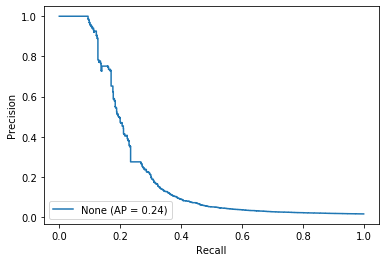

In [13]:
fig = plot_ap(y_test, y_pred_proba)

In [14]:
optimal_threshold, optimal_f1_score = get_optimal_f1_cutoff(y_test, y_pred_proba)
print("F1 Score: ", np.round(optimal_f1_score, 4))

F1 Score:  0.2876


In [15]:
cm = get_confusion_matrix(y_test, y_pred_proba, optimal_threshold)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[97946   509]
 [ 1200   345]]


In [16]:
roc_auc_score(y_test, y_pred_proba)

0.7285908877924451